In [1]:
from operator import itemgetter

import tqdm
import bs4
import feedparser
import seaborn as sns
import pandas as pd

In [2]:
medium_publications = [
    'the-artificial-impostor',
    'pytorch',
    'dair.ai',
    'towards-artificial-intelligence',
    'swlh',
    '@ODSC',
    'doctrine',
    'paperswithcode'
]


medium_url_template = 'https://medium.com/feed/{}'
medium_url = medium_url_template.format(medium_publications[0])
medium_urls = [medium_url_template.format(publication) for publication in medium_publications]

In [3]:
subreddits = [
    'MachineLearning',
    'deeplearning',
    'datascience',
    'cognitivelinguistics',
    'TopOfArxivSanity',
    'kaggle'
]

reddit_url_template = 'https://www.reddit.com/r/{}/.rss'
reddit_url = reddit_url_template.format(subreddits[0])
reddit_urls = [reddit_url_template.format(subreddit) for subreddit in subreddits]

In [4]:
feed = feedparser.parse(reddit_url)

In [5]:
len(feed['entries'])

26

In [6]:
articles = feed['entries']

In [7]:
def get_article_text(article):
    article_html_content = article['content'][0]['value']
    article_text = bs4.BeautifulSoup(article_html_content).text
    return article_text


def get_feed_article_texts(feed):
    return [get_article_text(article) for article in feed['entries'] if 'content' in article.keys()]


def get_feed_article_df(feed):
    feed_df = pd.DataFrame.from_records(feed['entries'])
    feed_df['text'] = feed_df['summary'].apply(lambda s: bs4.BeautifulSoup(s).text)
    return feed_df

In [8]:
feeds = [
    feedparser.parse(feed_url)
    for feed_url in tqdm.tqdm(medium_urls + reddit_urls)
]

100%|██████████| 14/14 [00:06<00:00,  2.15it/s]


In [9]:
feed_df = pd.concat(
    [
        get_feed_article_df(feed)
        for feed in feeds
        if len(feed['entries']) > 0
    ]
)

In [10]:
from ktrain import text 
zsl = text.ZeroShotClassifier()

In [38]:
example_article = feed_df.iloc[10]
example_article_text = example_article['text']

In [39]:
topic_strings = [
    'deep learning',
    'natural language processing',
    'computer vision',
    'visualization',
    'industry',
    'implementation',
    'computer programming',
    'reddit question',
    'research',
    'startup'
]
results = zsl.predict(example_article_text, topic_strings=topic_strings, include_labels=True, max_length=128)
results = sorted(results, key=itemgetter(1), reverse=True)

In [55]:
pd.set_option("display.max_colwidth", 250)

In [56]:
example_article[['title', 'text']]

title                                                                                                                                                                                                       AI for AG: Production machine learning for agriculture
text     Author: Chris Padwick, Director of Computer Vision and Machine Learning at Blue River TechnologyHow did farming affect your day today? If you live in a city, you might feel disconnected from the farms and fields that produce your food. Agricultur...
Name: 0, dtype: object

In [45]:
categories = [c for c, __ in results]
scores = [score for __, score in results]

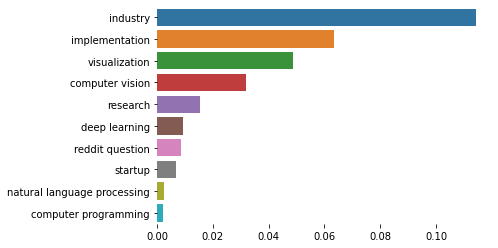

In [46]:
sns.barplot(scores, categories)
sns.despine(left=True, bottom=True)